# 스케일링과 변수 변환

회귀분석에 사용되는 데이터는 그 자체로 사용하기 보다는 스케일링이나 함수 변환 등의 전처리 과정을 거치는 경우가 많다. 샘플 평균이 0, 샘플 표준편차가 1이 되도록 scaling한다. 전처리 과정은 공분산 행렬의 조건을 향상시키거나 데이터 간의 관계를 선형 모형에 맞게 바꾸기 위해 사용된다.

## 조건수

**조건수**(conditional number)는 공분산 행렬 $X^TX$의 가장 큰 고유치와 가장 작은 고유치의 비율을 뜻한다. $X^TX$는 고유분해 하면 양수가 나온다.

$$ \text{condition number} = \dfrac{\lambda_{\text{max}}}{\lambda_{\text{min}}} $$



조건수가 크면  역행렬을 계산할 때 오차가 미치는 영향이 커진다. 

예를 들어 다음 연립방정식의 해를 구해보자.

$$ Ax = b $$

행렬 $A$는 covariance matrix이고, feature matrix에서 구해진다. 측정기기에서 단위 정밀성 부족 등으로 실제에서 조사오차가 발생할 수 있다. 이 때 행렬 $A$가 단위 행렬이면 조건수는 1이다. 조건수가 1일 때는 내가 조사할 때 생긴 오차만큼 동일하게 $x$값도 오차가 생긴다. 하지만 조건수가 커질 수록 내가 오차를 조금 만들어도 $x$값이 실제와 크게 달라진다.

In [1]:
A = np.eye(4)

이 행렬 $A$와 곱해져서 상수 벡터 $b$가 되는 벡터 $x$를 역행렬 $A^{-1}$을 사용하여 계산할 수 있다. 이 예에서는 상수 벡터 $b$가 1-벡터이다.

In [2]:
b = np.ones(4)
sp.linalg.solve(A, b)

array([1., 1., 1., 1.])

만약 상수 벡터에 약간의 오차가 있었다면 연립방정식의 해에도 동일한 수준의 오차가 발행한다.

In [3]:
sp.linalg.solve(A + 0.0001 * np.eye(4), b)

array([0.99990001, 0.99990001, 0.99990001, 0.99990001])

하지만 연립방정식을 이루는 행렬의 조건수가 커지면 상수항 오차가 작은 경우에도 해의 오차가 커지게 된다. 예를 들어 다음과 같은 행렬을 생각하자.

In [4]:
A = sp.linalg.hilbert(4)
A

array([[1.        , 0.5       , 0.33333333, 0.25      ],
       [0.5       , 0.33333333, 0.25      , 0.2       ],
       [0.33333333, 0.25      , 0.2       , 0.16666667],
       [0.25      , 0.2       , 0.16666667, 0.14285714]])

In [5]:
np.linalg.cond(A)

15513.738738929038

이 행렬과 곱해져서 상수 벡터가 되는 벡터를 역행렬을 사용하여 찾으면 다음과 같다.

In [6]:
sp.linalg.solve(A, b)

array([  -4.,   60., -180.,  140.])

조건수가 크면 약간의 오차만 있어도 해가 전혀 다른 값을 가진다. 따라서 조건수가 크면 회귀분석을 사용한 예측값도 오차가 커지게 된다. 여기에서 역행렬 값이 틀렸다는 것을 의미하지는 않는다.

In [7]:
sp.linalg.solve(A + 0.0001 * np.eye(4), b)

array([ -0.58897672,  21.1225671 , -85.75912499,  78.45650825])

조건수가 높으면 회귀분석에서 구한 $w$가 자연계 $w$와 상관없을 수 있고, 새로운 데이터를 넣었을 때 이상한 값이 나올 것이다. 즉, 조건수가 높으면 그 모형을 믿을 수 없다. $X^TX$의 pdf가 원이 아니고 타원의 형태를 보이면 최대, 최소의 $\lambda$값이 많이 차이나므로 조건수가 나빠진다.

회귀분석에서 조건수가 커지는 경우는 크게 두 가지가 있다.

1. 변수들의 단위 차이로 인해 숫자의 스케일이 크게 달라지는 경우. 이 경우에는 스케일링(scaling)으로 해결한다. - $x_1$(단위 mm)의 분산은 작은데 $x_2$(단위 km)의 분산은 클 때
1. 다중 공선성 즉, 두 변수가 동일하지는 않으나 상관관계가 큰 독립 변수들이 있는 경우, 이 경우에는 변수 선택(둘 중 한 변수 제거)이나 PCA를 사용한 차원 축소(feature matrix를 회전시켜서 basis vector가 조금만 움직인 변수가 영향이 적을 것이라고 가정하고 그 변수를 제거) 등으로 해결한다.

## 스케일링

스케일링을 하면 $R^2$ 값은 동일하고 조건수만 감소한다. 
보스턴 집값 데이터의 경우 회귀분석을 하면 조건수가 15,000 정도로 크게 나오는데 이는 각 독립 변수들이 0.1 단위부터 수백 단위까지 제각각의 크기를 가지고 있기 때문이다.

In [18]:
from sklearn.datasets import load_boston
boston = load_boston()
dfX = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df = pd.concat([dfX, dfy], axis=1)

model1 = sm.OLS.from_formula("MEDV ~ CRIM + ZN + INDUS + NOX + RM + AGE + "
                             "DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Mon, 09 Jul 2018   Prob (F-statistic):          6.95e-135
Time:                        16:07:12   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4911      5.104      7.149      0.0

- 각각의 회귀계수는 다른 독립변수는 고정되어 있고 특정 독립변수가 1단위 변할 때 종속변수가 변화하는 평균을 의미한다. 예를 들어 모든 독립변수가 동일한 두 집을 비교할 때 한 집의 NOX 농도가 1단위 증가하면 그 집의 가격은 평균적으로 17.8 감소한다는 뜻이다.
- 상수항은 모든 독립변수가 0인 경우에 예측되는 가격이다.

$*$ 클린턴 브라운리, '파이썬 데이터 분석 입문', 한빛미디어, 2017

In [10]:
result1.predict(df[:1])

0    30.008213
dtype: float64

- StatsModels에서는 모형지정 문자열에서 `scale` 명령을 사용하여 스케일링을 할 수 있다. 이 방식으로 스케일을 하면 스케일링에 사용된 평균과 표준편차를 저장하였다가 나중에 `predict` 명령을 사용할 때도 같은 스케일을 사용하기 때문에 편리하다. Scikit-Learn의 파이프라인과 같은 역할을 한다.

In [11]:
model2 = sm.OLS.from_formula("MEDV ~ "
                             "scale(CRIM) + scale(ZN) + scale(INDUS) + scale(NOX) + scale(RM) + scale(AGE) + "
                             "scale(DIS) + scale(RAD) + scale(TAX) + scale(PTRATIO) + scale(B) + scale(LSTAT) + CHAS", 
                             data=df)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Mon, 09 Jul 2018   Prob (F-statistic):          6.95e-135
Time:                        16:03:37   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         22.3468      0.219    101.

- 독립변수가 표준화되면 회귀계수의 해석도 달라진다. 표준화 후 분석한 회귀계수는 다른 독립변수는 고정되어 있고 특정 독립변수가 1표준편차만큼 변할 때 종속변수가 변화하는 표준편차의 평균을 의미한다. 모든 독립변수가 동일한 두 집을 비교할 때 한 집의 NOX가 1표준편차만큼 증가하면 그 집의 가격은 평균적으로 약 2.06표준편차만큼 감소한다는 뜻이다. 
- 절편에 대한 해석도 달라지는데 모든 독립변수가 평균일 때에 해당하는 종속변수의 평균을 의미한다. 이 회귀모형에서 집의 모든 특성이 평균일 때 가격의 평균은 절편에 해당하는 22.3468이고 표준오차는 0.219가 되리라고 기대할 수 있다.

$*$ 클린턴 브라운리, '파이썬 데이터 분석 입문', 한빛미디어, 2017

In [12]:
result2.predict(df[:1])

0    30.008213
dtype: float64

## 변수 변환

다음과 같은 경우에는 로그 함수 혹은 제곱근 함수 등을 사용하여 변환된 변수를 사용하면 회귀 성능이 향상될 수도 있다. 실제로 비선형 관계에 있는 변수를 변수변환해서 선형모델로 분석할 수 있게 하는 것이다.

* 독립 변수나 종속 변수가 심하게 한쪽으로 치우친 분포를 보이는 경우 
* 독립 변수와 종속 변수간의 관계가 곱셈 혹은 나눗셈으로 연결된 경우
* 종속 변수와 예측치가 비선형 관계를 보이는 경우

**원래 선형회귀모형의 가정에는 독립 변수나 종속 변수가 반드시 대칭 분포를 보여야 한다는 가정은 없지만 정규 분포에 가까운 분포를 보일 수록 선형회귀모형의 성능이 좋아지는 경우가 많다.** partial regression, CCPR, 변수분포를 보고 어떤 관계인지, 변수를 어떻게 처리해야 하는지 고민해서 처리한다.

보스턴 집값 데이터에서는 가격, DIS, PTRATIO, LSTAT 등이 비대칭 분포를 이루거나 가격과 반비례 관계를 가지므로 이 변수들을 로그로 변환한 후에 선형회귀분석을 하면 성능을 향상시킬 수 있다.

In [13]:
model3 = sm.OLS.from_formula("np.log(MEDV) ~ "
                             "scale(CRIM) + scale(I(CRIM ** 2)) + scale(ZN) + scale(I(ZN ** 2)) + "
                             "scale(INDUS) + scale(NOX) + scale(RM) + scale(AGE) + "
                             "scale(np.log(DIS)) + scale(RAD) + scale(TAX) + "
                             "scale(np.log(PTRATIO)) + scale(B) + scale(np.log(LSTAT)) + CHAS", 
                             data=df)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(MEDV)   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     145.4
Date:                Mon, 09 Jul 2018   Prob (F-statistic):          1.97e-169
Time:                        16:03:40   Log-Likelihood:                 164.24
No. Observations:                 506   AIC:                            -296.5
Df Residuals:                     490   BIC:                            -228.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3

In [14]:
# 아웃라이어 제거
influence3 = result3.get_influence()
cooks_d2, pvals = influence3.cooks_distance
fox_cr = 4 / (len(df) - 2)
idx_outlier = np.where(cooks_d2 > fox_cr)[0]
# MEDV = 50 제거
idx_outlier = np.hstack([idx_outlier, np.where(boston.target == 50)[0]])
idx_outlier

array([  7,  54, 148, 152, 160, 214, 253, 267, 364, 365, 367, 368, 369,
       371, 372, 374, 380, 385, 397, 398, 399, 400, 401, 405, 409, 410,
       412, 413, 414, 415, 416, 418, 419, 426, 445, 489, 490, 492, 505,
       161, 162, 163, 166, 186, 195, 204, 225, 257, 267, 283, 368, 369,
       370, 371, 372], dtype=int64)

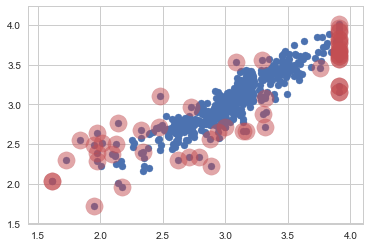

In [15]:
%matplotlib inline
pred = result3.predict(df)
ax = plt.subplot()
plt.scatter(np.log(dfy), pred)
plt.scatter(np.log(dfy.MEDV[idx_outlier]), pred[idx_outlier], s=300, c="r", alpha=0.5)
plt.show()

In [16]:
idx = list(set(range(len(df))).difference(idx_outlier))
df4 = df.iloc[idx, :].reset_index(drop=True)

In [17]:
model4 = sm.OLS.from_formula("np.log(MEDV) ~ "
                             "scale(CRIM) + scale(I(CRIM ** 2)) + scale(ZN) + scale(I(ZN ** 2)) + "
                             "scale(INDUS) + scale(NOX) + scale(RM) + scale(AGE) + "
                             "scale(np.log(DIS)) + scale(RAD) + scale(TAX) + "
                             "scale(np.log(PTRATIO)) + scale(B) + scale(np.log(LSTAT)) + CHAS", 
                             data=df4)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(MEDV)   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     199.9
Date:                Mon, 09 Jul 2018   Prob (F-statistic):          1.56e-185
Time:                        16:03:43   Log-Likelihood:                 317.45
No. Observations:                 456   AIC:                            -602.9
Df Residuals:                     440   BIC:                            -536.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3